In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *
%pylab inline
#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)



/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
with open('interpulses.txt', 'r') as f:
    text = f.read()
    interpulses = text.split('\n')
    
with open('mainpulses.txt', 'r') as f:
    text = f.read()
    mainpulses = text.split('\n')

In [46]:
pwd()

u'/cita/h/home-2/xzxu/packages/scint_analysis/EVN_crab'

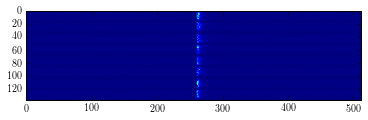

In [14]:
gp = np.load('./GPs/p{}.npy'.format(time_string1))
gp.shape
imshow(gp)

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


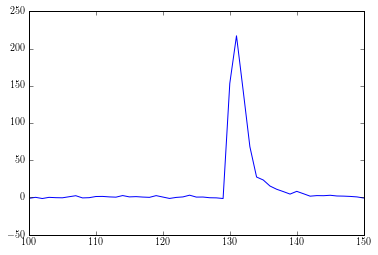

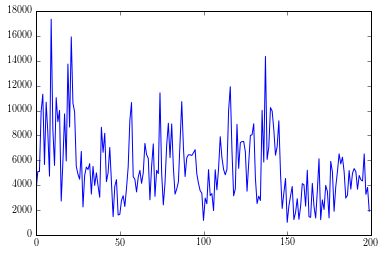

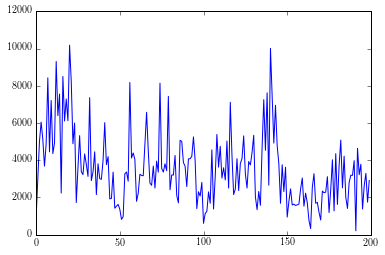

In [44]:
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:5]) 
    noise_mean = np.mean(outputsumfreq[:5])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
    return sigs_noise

def process_freq_spec(gp1,nchan,draw=0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, 
    then stitch the 8 bands together to compute a correlation coefficient. 
    function also plots the frequency spectrum if draw = 1'''
    gp1_stitched=gp1[int(50./512*nchan):int(460./512*nchan)]
    for j in range(7):gp1_stitched=np.concatenate((gp1_stitched,gp1[(j+1)*(nchan+1)+int(50./512*nchan):(j+1)*(nchan+1)+int(460./512*nchan)]),0)
    if draw:
        figure()
        plot(gp1_stitched)
    
    if nchan == 512:
        new1 = np.zeros((8,25))
        for i in range(8):
            for j in range(25):
                new1[i,j] = average(gp1_8[i,j*N:(j+1)*N])
        return new1,gp1_8
    return gp1_stitched

def load_gp(time_string,telescope,nchan,draw = 0):
    '''Takes in a time string, a string indicating whcih telescope to use, and an interger of nchan'''
#     output = np.load('./GPs/p{}.npy'.format(time_string))
    gp1 = np.load('/mnt/raid-cita/ramain/GPs/GP{}/p{}.npy'.format(telescope,time_string))

    gp1t = np.fft.irfft(gp1,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T

    outputsumfreq = output.sum(0) #dedispersed
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    
    peak_time = np.argmax(sigs_noise)
    S_N = outputsumfreq[peak_time]/np.mean(outputsumfreq[:5])
    
    if nchan ==512:
        background_std = []
        for j in range(8):
            background_std.append(output[j*(nchan+1)+40./512*nchan:j*(nchan+1)+465./512*nchan,:peak_time-3].std())
        output_pulse = output[:,peak_time]
#         print 'std2 =',background_std2
        background_freq = output[:,peak_time-3]

    if nchan == 128:
        sn_sorted = np.argsort(sigs_noise)
#         print sn_sorted
#         print sn_sorted.shape
        background_freq = (output[:,sn_sorted[30]]+output[:,sn_sorted[31]])/2
        output_pulse = (output[:,sn_sorted[-1]]+output[:,sn_sorted[-2]])/2
        background_std = []
        for j in range(8):
            background_std.append(background_freq[j*(nchan+1)+40./512*nchan:j*(nchan+1)+465./512*nchan].std())
            
    if nchan ==32:
        sn_sorted = np.argsort(sigs_noise)
        background_1= np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(51,58)],axis = 0).mean(0) 
        output_pulse = np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(1,8)],axis = 0).mean(0)
#         background_1 = output[:,sn_sorted[-51]]
#         output_pulse = output[:,sn_sorted[-1]]
        background_std = []
        for j in range(8):
            background_std.append(background_1[j*(nchan+1)+40./512*nchan:j*(nchan+1)+465./512*nchan].std())
        background_std = np.std(background_1)
        background_freq = background_1
    
    
    if nchan ==16:
        sn_sorted = np.argsort(sigs_noise)
#         print sn_sorted
        background_1= np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(51,56)],axis = 0).sum(0) 
        output_pulse = np.concatenate([np.array([output[:,sn_sorted[-k]]]) for k in range(1,6)],axis = 0).sum(0)
#         background_1 = output[:,sn_sorted[-101]]
#         output_pulse = output[:,sn_sorted[-1]]
        background_std = np.std(background_1)
        background_freq = background_1
        
    freq_spec = output_pulse-background_freq
#     freq_spec = output_pulse
    
    
    if draw:
        figure(figsize = (10,3))
        plot(outputsumfreq)
        figure()
        plot(output_pulse)
        plot(background_freq)
        figure()
        plot(freq_spec)
    return freq_spec,background_std,sigs_noise, S_N


nchan = 32
tele1 = 'jb'
tele2 = 'ef'
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse
time_string5 = '2015-10-19T00:55:15.557' #S/N = 8.33, main pulse
time_string6 = '2015-10-19T00:55:49.673' #S/N = 8.55, main pulse
time_string7 = '2015-10-19T01:29:52.509' #S/N = 8.44, main pulse
time_string8 = '2015-10-19T01:55:06.340' #S/N = 8.66, main pulse
time_string9 = '2015-10-19T02:13:46.551' #S/N = 9.56, main pulse
time_string10 = '2015-10-19T02:36:11.418'#S/N = 8.41, main pulse

time_string = time_string10
fs1,bgstd1,os1,sn1 = load_gp(time_string2,tele1,nchan)
fs2,bgstd2,os2,sn2 = load_gp(time_string2,tele2,nchan)

figure()
plot(os1)
xlim(100,150)
fgp1 = process_freq_spec(fs1,nchan,draw = 1)
fgp2 = process_freq_spec(fs2,nchan,draw = 1)


In [45]:
def get_cc((fs1,bgstd1),(fs2,bgstd2)):
    mean1 = np.mean(fs1)
    mean2 = np.mean(fs2)
    numerator = np.mean((fs1-mean1)*(fs2-mean2))
    denominator = np.sqrt((np.std(fs1)**2-bgstd1**2)*(np.std(fs2)**2-bgstd2**2))
#     denominator = np.std(fs1)*np.std(fs2)
    return numerator/denominator
    
def get_ccs((fs1,bgstd1),(fs2,bgstd2)):
    coefficients= []
    for i in range(8):
        X = fs1[i]
        Y = fs2[i]
        Xbg = bgstd1[i]
        Ybg = bgstd2[i]
        coefficient = get_cc((X,Xbg),(Y,Ybg))
        coefficients.append(coefficient) 
    return np.mean(coefficients),coefficients

get_cc((fgp1,bgstd1),(fgp2,bgstd2))

0.70329815365008708

In [7]:
colors = [(31, 119, 180),(255, 127, 14), (44, 160, 44),(148, 103, 189),(214, 39, 40)] #blue, orange, green, purple, red
for i in range(len(colors)):    
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [13]:
nchan = 16
# N = 410/25 #N is how many points I average into 1 in process frequency function. 
ctvalue = np.zeros(shape = (0,2))
for i,time_string1 in enumerate(mainpulses[:-1]):
    t_gp1 = Time(time_string1)
#     if exists('/home/ramain/GPs/GP{}/p{}.npy'.format('p',time_string1)): 
    if exists('./GPs/p{}.npy'.format(time_string1)):
        fs1,bgstd1,os1,sn1 = load_gp(time_string1,'p',nchan)
        if sn1<1.:
            continue
        for j,time_string2 in enumerate(mainpulses[i+1:-1]):
            t_gp2 = Time(time_string2)
            dt = t_gp2-t_gp1
            if 0.01<abs(dt.sec)<1000:
                if exists('./GPs/p{}.npy'.format(time_string2)):
                    fs2,bgstd2,os2,sn2 = load_gp(time_string2,'p',nchan)
                    if sn2<1.:
                        continue 
                    fgp1 = process_freq_spec(fs1,nchan,i-1,draw = 0)
                    fgp2 = process_freq_spec(fs2,nchan,i+j-1)
                    cc,ccs=get_cc((fgp1,bgstd1),(fgp2,bgstd2))
                    ctvalues=np.append(ctvalues,np.array([[cc,abs(dt.sec)]]),axis = 0)
#                     if 0.01<abs(dt.sec)<10:
#                         figure(figsize = (10,3))
#                         plot(fgp1[0]/fgp1[0].mean()-1.,label = 'pulse1',color = colors[0])
#                         plot(fgp2[0]/fgp2[0].mean()-1.,label = 'pulse2',color = colors[1])
#                         # plot(fgp3[0]/fgp3[0].mean()-1.,label = 'jb',color = colors[2])
#                         legend()
#                         title('Correlation of two main pulses separated by {}s. The correlation coefficient is {}'.format(round(dt.sec,3),round(ccs[0],3)))
#                         xlabel('Frequency channel')
#                         ylabel('Power')
np.save('./figures/correlation_coeff/ctvalues_jul26_mainpulses-n.npy',ctvalues)


ValueError: total size of new array must be unchanged

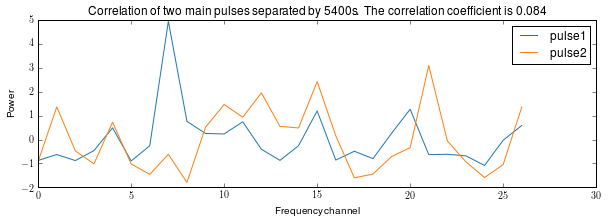

In [8]:
figure(figsize = (10,3))
plot(fgp1[0]/fgp1[0].mean()-1.,label = 'pulse1',color = colors[0])
plot(fgp2[0]/fgp2[0].mean()-1.,label = 'pulse2',color = colors[1])
# plot(fgp3[0]/fgp3[0].mean()-1.,label = 'jb',color = colors[2])
legend()
# title('Correlation of a pulse at wb(S/N = {}), ef(S/N = {}) and jb(S/N = {}). \n The correlation coefficient calculated for the 1st band is {}(ef-jb), {}(ef-wb), {}(wb-jb)'.format(round(sn1,3),round(sn2,3),round(sn3,3),round(ccs23[0],3),round(ccs12[0],3),round(ccs13[0],3)))
title('Correlation of two main pulses separated by 5400s. The correlation coefficient is {}'.format(round(ccs[0],3)))
xlabel('Frequency channel')
ylabel('Power')

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


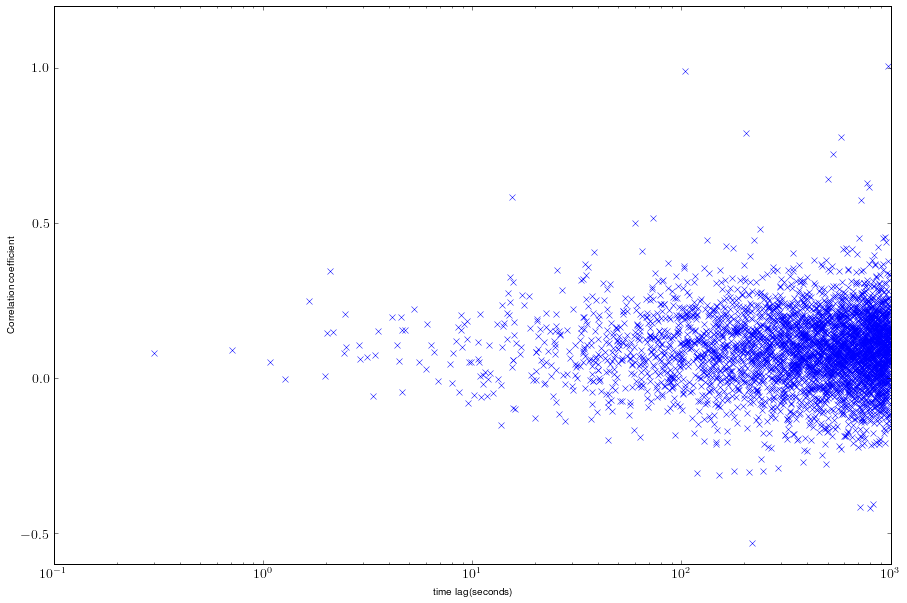

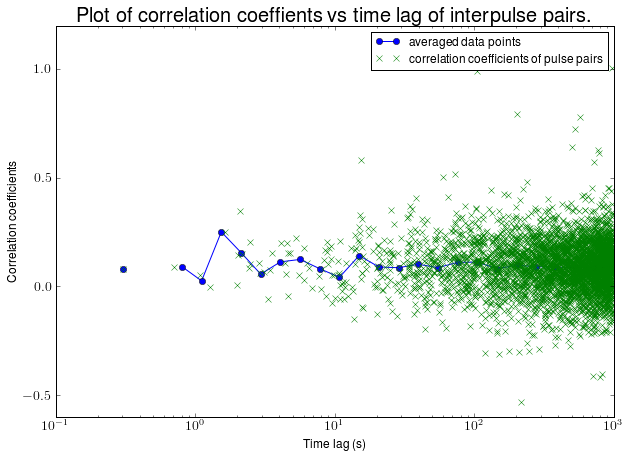

In [12]:
nchan = 512
ctvalues = np.load('./figures/correlation_coeff/{}_{}ctvaluesef_jul20_mainpulses-n.npy'.format(text_name,nchan))
# np.save('./figures/correlation_coeff/{}_{}ctvaluesef_jul5.npy'.format(text_name,nchan),ctvalues)

figure(figsize = (15,10))
semilogx(ctvalues[:,1],ctvalues[:,0],'x')
xlabel('time lag(seconds)')
# ylim(-0.2,0.5)
ylabel('Correlation coefficient')
tick_params(axis='both', which='major', labelsize=14)

bin_no = 35
time_values = ctvalues[:,1]
cvalues = ctvalues[:,0]
time_values[np.isnan(cvalues)]=0
cvalues[np.isnan(cvalues)]=0
bins = np.logspace(-1.3,3.5,bin_no)
bin_means = np.histogram(time_values,bins,weights = cvalues,density = False)[0]/np.histogram(time_values,bins,density = False)[0]

figure(figsize = (10,7))
semilogx((bins[:-1]+bins[1:])/2,bin_means,'-o',label = 'averaged data points'.format(bin_no))
semilogx(time_values,cvalues,'x',label = 'correlation coefficients of pulse pairs')
# plt.xlim(0.01,300)
# plt.ylim(-0.2,0.6)
legend()
title('Plot of correlation coeffients vs time lag of interpulse pairs.'.format(nchan),fontsize = 20)
xlabel('Time lag (s)',fontsize = 12)
ylabel('Correlation coefficients',fontsize=12)
xlim(0.1,1000)
tick_params(axis='both', which='major', labelsize=14)


In [16]:
text_lines


['2015-10-18T23:11:29.352',
 '2015-10-18T23:14:03.584',
 '2015-10-18T23:14:08.202',
 '2015-10-18T23:14:08.202',
 '2015-10-18T23:16:40.209',
 '2015-10-18T23:17:40.991',
 '2015-10-18T23:18:21.412',
 '2015-10-18T23:19:34.431',
 '2015-10-18T23:21:15.365',
 '2015-10-18T23:21:34.479',
 '2015-10-18T23:21:42.604',
 '2015-10-18T23:21:58.347',
 '2015-10-18T23:24:57.627',
 '2015-10-18T23:25:08.313',
 '2015-10-18T23:27:06.743',
 '2015-10-18T23:27:23.667',
 '2015-10-18T23:28:34.192',
 '2015-10-18T23:29:22.278',
 '2015-10-18T23:29:31.212',
 '2015-10-18T23:30:59.961',
 '2015-10-18T23:31:38.461',
 '2015-10-18T23:31:40.955',
 '2015-10-18T23:33:00.313',
 '2015-10-18T23:34:42.662',
 '2015-10-18T23:39:43.405',
 '2015-10-18T23:40:57.908',
 '2015-10-18T23:41:53.277',
 '2015-10-18T23:43:53.008',
 '2015-10-18T23:45:19.681',
 '2015-10-18T23:45:26.558',
 '2015-10-18T23:46:10.046',
 '2015-10-18T23:47:12.817',
 '2015-10-18T23:47:12.817',
 '2015-10-18T23:47:20.315',
 '2015-10-18T23:47:20.807',
 '2015-10-18T23:47:2